

**The 1st solution solution combines a CNN and a FC Classifier and achieves pretty good performance (>94%)**. It :
- crops the image around the characters and flips the cropped image (as we want the time dimension to correspond to the width of the image).  
- uses a CNN to extract features from the cropped image.
- reshapes the features to "split" them into 5 time-steps. 
- uses a FC Classifier to predict 5 characters : for each time-step, the output is the probability distribution of a character being at this step.  

**The 2nd solution implements a CNN LSTM architecture with CTC operation and achieves great performance (>99%). All the credits for this solution go to**. It:
- flips the input image (as we want the "time dimension" to correspond to the width of the image).
- uses a CNN to extract features from the image.
- uses a CNN encoder (which consists of a single Fully Connected layer) to encode the features into 50 time-steps
- uses 2 BRNNs to process a sequence of 50 steps : for each time-step, the output is the probability distribution of a character being at this step.
- uses a CTC decoder to predict 5 characters.  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_folder = 'samples/'

A quick overview of the dataset provided by @fournierp https://www.kaggle.com/fournierp/captcha-version-2-images :
- The dataset contains 1070 files. 
- Each file is an image representing a CAPTCHA image. 
- The image is either in png format (1040 png files) or in jpg format (30 jpg files). 
- The file name is composed of the 5 characters contained in the CAPTCHA image followed by the image format (e.g. 2g7nm.png) 

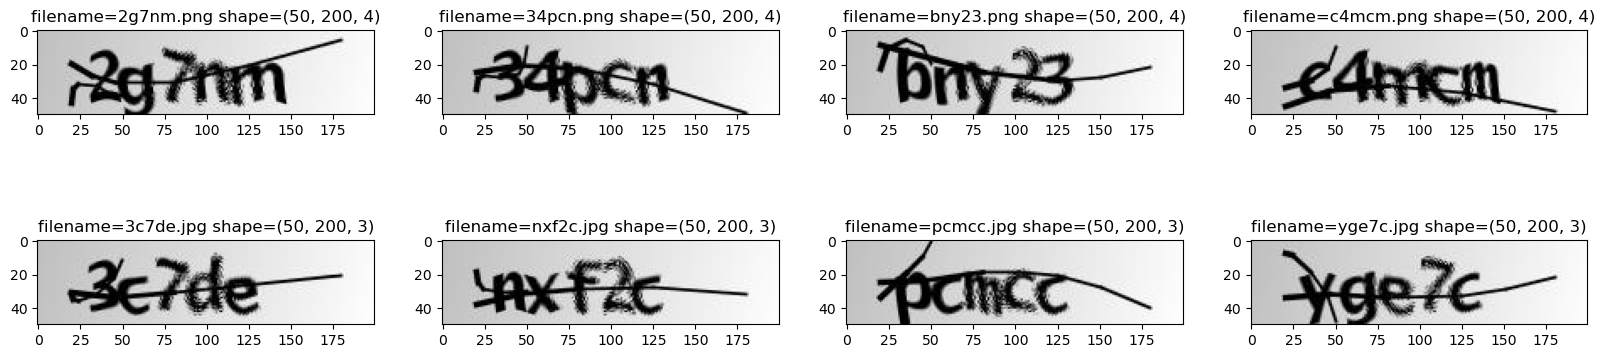

In [2]:
img_2g7nm = mpimg.imread(img_folder + '2g7nm.png')
img_34pcn = mpimg.imread(img_folder + '34pcn.png')
img_bny23 = mpimg.imread(img_folder + 'bny23.png')
img_c4mcm = mpimg.imread(img_folder + 'c4mcm.png')
img_3c7de = mpimg.imread(img_folder + '3c7de.jpg')
img_nxf2c = mpimg.imread(img_folder + 'nxf2c.jpg')
img_pcmcc = mpimg.imread(img_folder + 'pcmcc.jpg')
img_yge7c = mpimg.imread(img_folder + 'yge7c.jpg')
samples = {'2g7nm.png':img_2g7nm, '34pcn.png':img_34pcn, 'bny23.png':img_bny23, 'c4mcm.png':img_c4mcm, 
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Each image has 50x200 pixels. That said, the shape of the array differs between jpg and png images indicating that jpg images are RGB and png are RGBA. Since images are black & white, R, G and B are all similar. Also for png images, there is no differecence in transparency (alpha is always 1). 

Now, looking at the characters in the CAPTCHA images, one can notice that:
- only 19 characters are used 2,3,4,5,6,7,8 and b,c,d,e,f,g,m,n,p,w,x,y
- the frequency of each character is roughly the same with one exception : n is used twice often than other characters

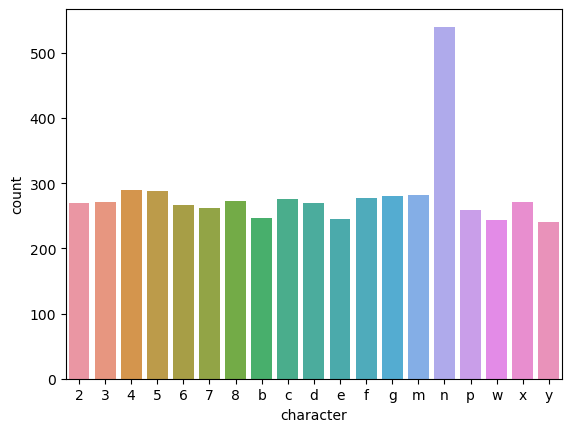

In [3]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1
        
#df.head()

data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

We will assess the performance of the different models on the validation dataset that contains 10% of the complete dataset. 

For each image in the validation set, we will compare the true label with the prediction. The true label and the prediction are (5,1) vectors. Therefore we will compare the vectors element-wise and count the number of good predictions element-wise. For each image, the score will be (nb of good predictions element-wise)/5. 

E.g. :   
- the true label corresponding to the image 368y5.png is [1 4 6 18 3] (after transforming the characters to numerical values)
- if the predicted label is [1 4 6 18 3], then the score for this image is 1
- if the predicted label is [2 6 4 10 1], then the score for this image is 0
- if the predicted label is [1 6 6 10 1], then the score for this image is 0.4 (2 characters correctly predicted)

**The performance of the model will be the average of the scores for each image in the validation set. This number corresponds to the percentage of characters that are correctly predicted.**

In [4]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

In [5]:
def compute_act_metric(predictions, groundtruth):
    correct_count = 0
    total_count = predictions.shape[0]
    
    for i in range(total_count):
        if np.array_equal(predictions[i], groundtruth[i]):
            correct_count += 1
    
    return correct_count / total_count

This section generates the training set that will be used to train the neural network and the validation set that will be used to evaluate the model performance.

The training set will have 90% of the data :
- X_train with 936 images. X_train shape will be (936,50,200,1) 
- y_train with 936 labels. y_train shape will be (936,5)  

The validation set will have 10% of the data 
- X_val with 104 images. X_val shape will be (104,50,200,1) 
- y_val with 104 labels. y_val shape will be (104,5)

The label corresponding to each image is a string corresponding to the filename minus the extension. As the neural net deals only with numerical values, we will have to map each character in the string to an integer.

In [6]:
# Dictionaries that will be used to convert characters to integers and vice-versa
vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

##############################################################################################################################
# This function encodes a single sample. 
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split X, y to get X_train, y_train, X_val, y_val 
    X_train1, X_val, y_train1, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=True, random_state=42)
    X_train, X_val,X_test = X_train.reshape(748,200,50,1), X_val.reshape(104,200,50,1),X_test.reshape(188,200,50,1)
    return X_train, X_val, y_train, y_val, X_test,y_test

Let's check a few examples :   
- images on the 1st row are transposed, cropped around the characters and resized as expected by the "classifier-like" model
- images on the 2nd row are transposed only as expected by the CNN LSTM model

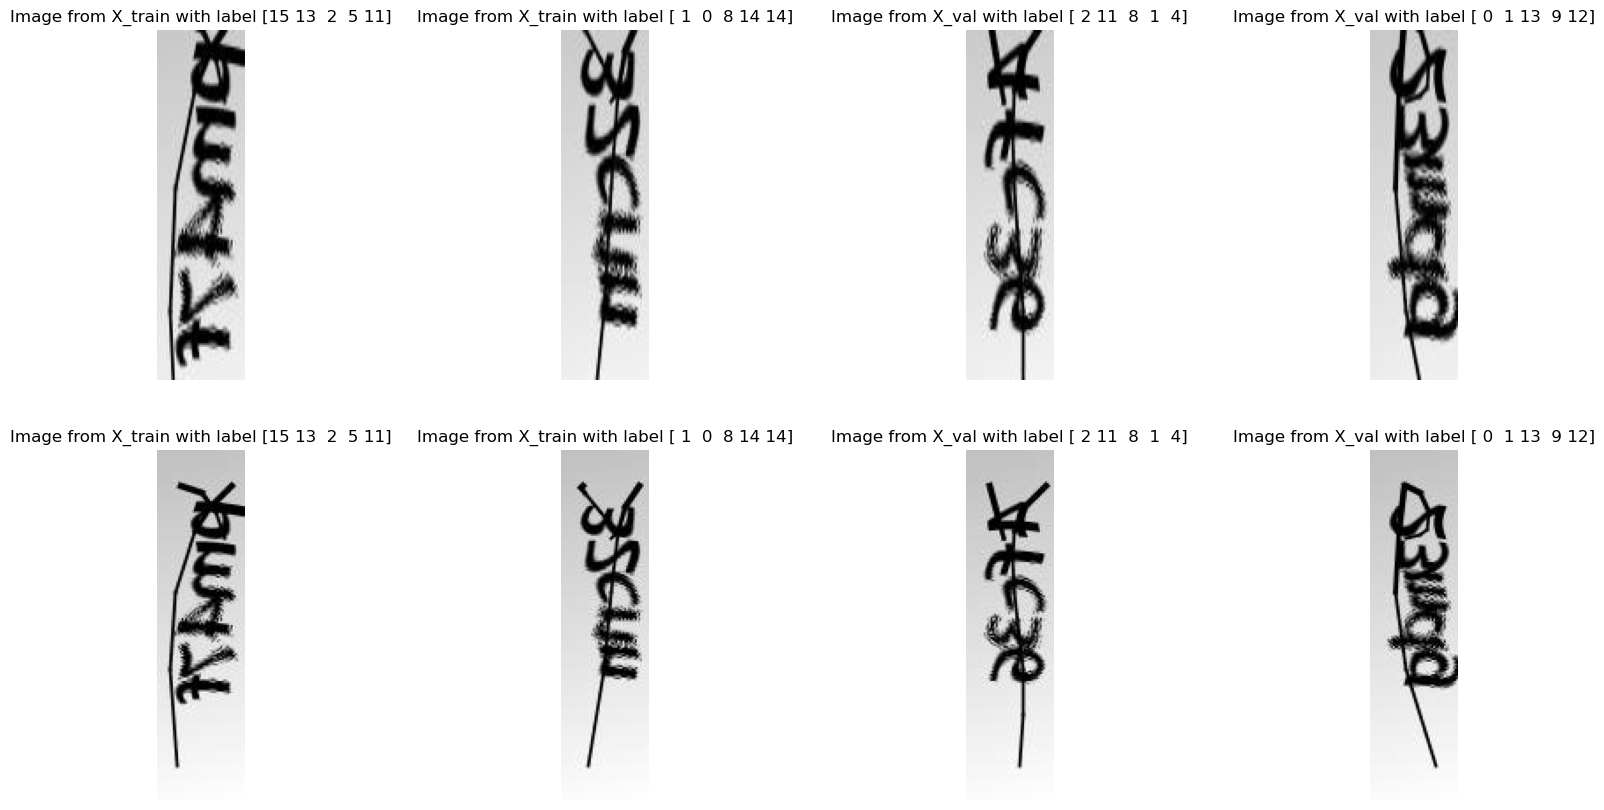

In [7]:
X_train, X_val, y_train, y_val,X_test,y_test = create_train_and_validation_datasets(crop=True)
X_train_, X_val_, y_train_, y_val_,X_test_,y_test_ = create_train_and_validation_datasets(crop=False)

fig=plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[700], cmap='gray')
#plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[700]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_val[0], cmap='gray')
#plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_val[103], cmap='gray')
#plt.imshow(X_val[103].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_val with label '+ str(y_val[103]))
plt.axis('off')
fig.add_subplot(2, 4, 5)
plt.imshow(X_train_[0], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
plt.imshow(X_train_[700], cmap='gray')
plt.title('Image from X_train with label '+ str(y_train_[700]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
plt.imshow(X_val_[0], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
plt.imshow(X_val_[103], cmap='gray')
plt.title('Image from X_val with label '+ str(y_val_[103]))
plt.axis('off')
plt.show()

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>The classifier-like model</p>
</div>

**This solution solution combines a CNN and a FC Classifier and achieves pretty good performance (>94%)**. It :
- crops the image around the characters and flips the cropped image (as we want the time dimension to correspond to the width of the image).  
- uses a CNN to extract features from the cropped image.
- reshapes the features to "split" them into 5 time-steps. 
- uses a FC Classifier to predict 5 characters : for each time-step, the output is the probability distribution of a character being at this step.  

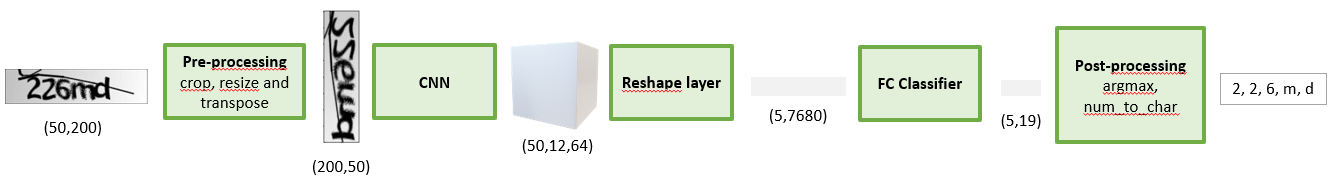

## Build Model

In [9]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(5, 7680), name="reshape")(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 5, 7680)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 5, 256)              │       1,966,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 5, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense3 (Dense)                       │ (None, 5, 19)               │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,002,835 (7.64 MB)

 Trainable params: 2,002,835 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [10]:
X_train, X_val, y_train, y_val,X_test,y_test = create_train_and_validation_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=40)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.0807 - loss: 3.2771 - val_accuracy: 0.2481 - val_loss: 2.4455
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.3629 - loss: 2.1127 - val_accuracy: 0.6077 - val_loss: 1.3031
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7177 - loss: 0.9672 - val_accuracy: 0.8019 - val_loss: 0.6394
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8583 - loss: 0.5090 - val_accuracy: 0.8654 - val_loss: 0.4427
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9028 - loss: 0.3666 - val_accuracy: 0.8731 - val_loss: 0.4111
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9246 - loss: 0.2728 - val_accuracy: 0.9000 - val_loss: 0.3288
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9208 - loss: 0.2651 - val_accuracy: 0.8885 - val_loss: 0.3427
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9530 - loss: 0.1610 - val_accuracy: 0.9077 - 

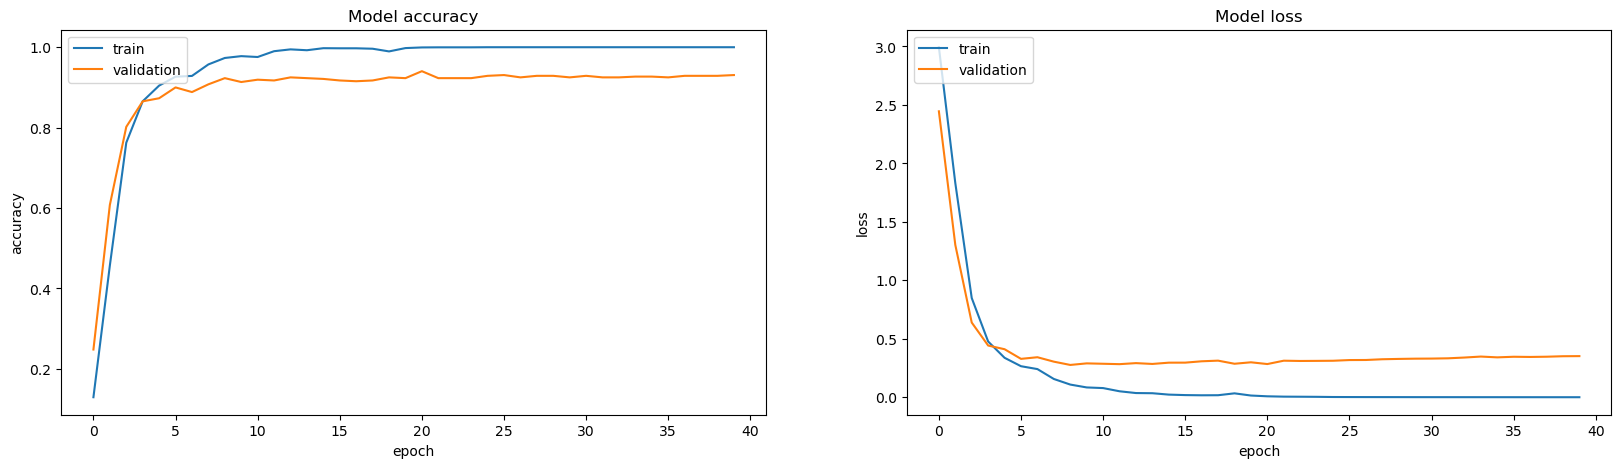

In [11]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions

Let's use this model to predict the labels for the 104 images of the validation set :

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


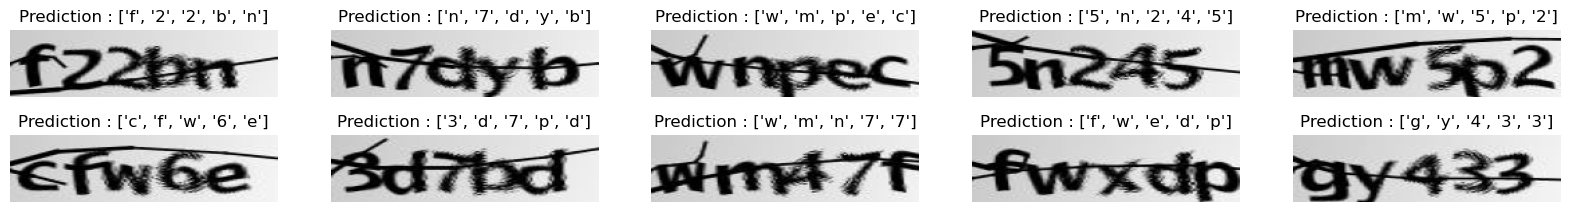

In [12]:
y_pred = model.predict(X_test) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_test[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 

## Model Performance

Let's use the function compute_perf_metric to calculate the performance metric of this model. Reminder : this metric corresponds to the percentage of characters that are correctly predicted (and this % is calculated using the 104 images hence 520 characters of the validation set).

In [13]:
compute_perf_metric(y_pred, y_test)

0.9287234042553192

In [14]:
compute_act_metric(y_pred, y_test)

0.7872340425531915

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>The CNN LSTM model</p>
</div>

**This solution implements a CNN LSTM architecture with CTC loss and achieves great performance (>99%). All the credits for this solution go to [A_K_Nain](https://keras.io/examples/vision/captcha_ocr/)**. It:
- flips the input image (as we want the "time dimension" to correspond to the width of the image).
- uses a CNN to extract features from the image.
- uses a CNN encoder (which consists of a single Fully Connected layer) to encode the features into 50 time-steps
- uses 2 BRNNs to process a sequence of 50 steps : for each step, the output is the probability distribution of a character being at this step.
- uses a CTC decoder to predict 5 characters.

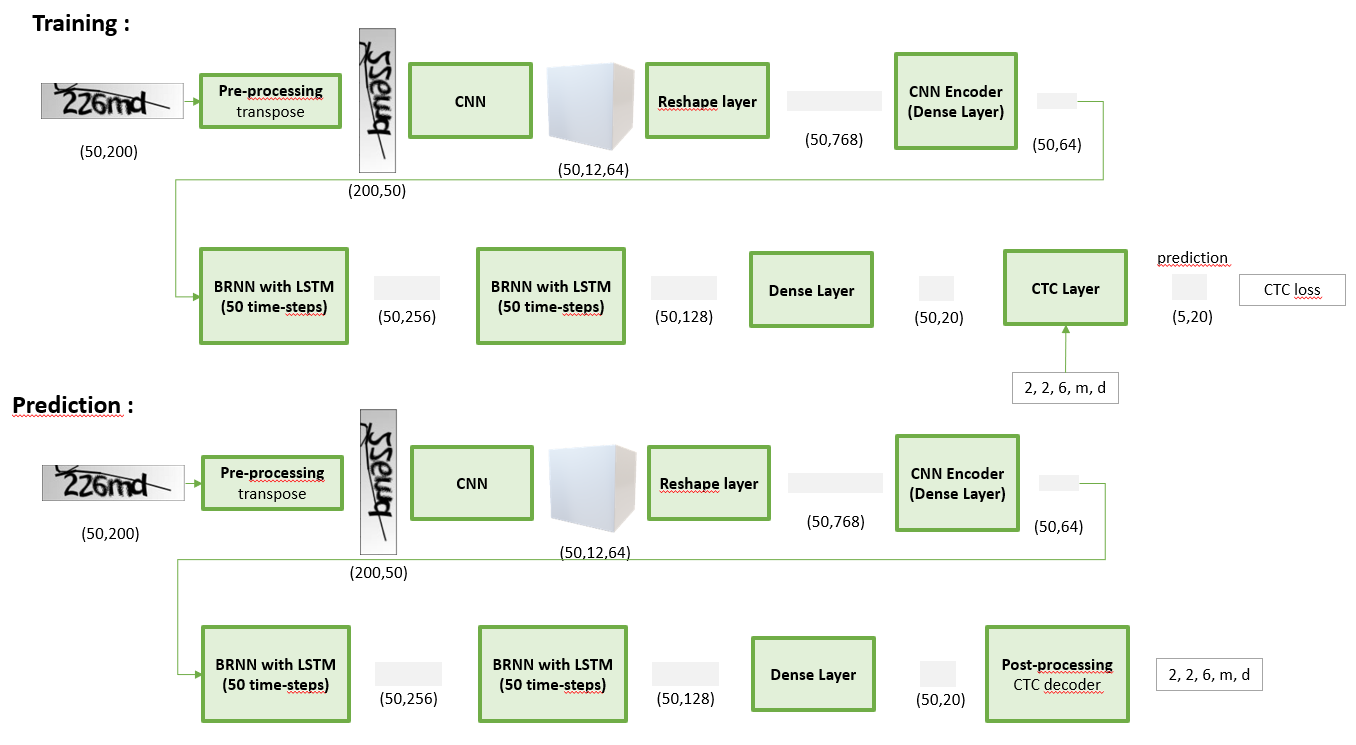


## Build Model

In [53]:
# Let's create a new CTCLayer by subclassing
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of////
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model 
    x = layers.Reshape(target_shape=(50, 768), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(20, activation="softmax", name="dense2")(x) # 20 = 19 characters + UKN

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_cnn_lstm_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam())
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_cnn_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 200, 50, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 200, 50, 32)       │             320 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 100, 25, 32)       │               0 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2 (Conv2D)                │ (None, 100, 25, 64)       │          18,496 │ pool1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool2 (MaxPooling2D)          │ (None, 50, 12, 64)        │               0 │ Conv2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 50, 768)           │               0 │ pool2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense1 (Dense)                │ (None, 50, 64)            │          49,216 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 50, 64)            │               0 │ dense1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_14              │ (None, 50, 256)           │         197,632 │ dropout_7[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_15              │ (None, 50, 128)           │         164,352 │ bidirectional_14[0][0]     │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense2 (Dense)                │ (None, 50, 20)            │           2,580 │ bidirectional_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_loss (CTCLayer)           │ (None, 50, 20)            │               0 │ label[0][0], dense2[0][0]  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [59]:
X_train, X_val, y_train, y_val,X_test,y_test = create_train_and_validation_datasets(crop=False)

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)

# Train the model
history = model.fit(
    x={'image': X_train, 'label': y_train}, 
    validation_data=({'image': X_val, 'label': y_val}),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 522.5927 - val_loss: 491.9065
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 522.4719 - val_loss: 492.6236
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 521.4632 - val_loss: 492.3876
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 521.9078 - val_loss: 491.4881
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 521.5611 - val_loss: 491.6936
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 520.7251 - val_loss: 492.9639
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 520.9565 - val_loss: 492.2402
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 520.9355 - val_loss: 492.0688
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 520.2509 - val_loss: 492.3732
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 520.6404 - val_loss: 492.1006
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 520.6860 - val_loss: 491.4576
Epoch 12

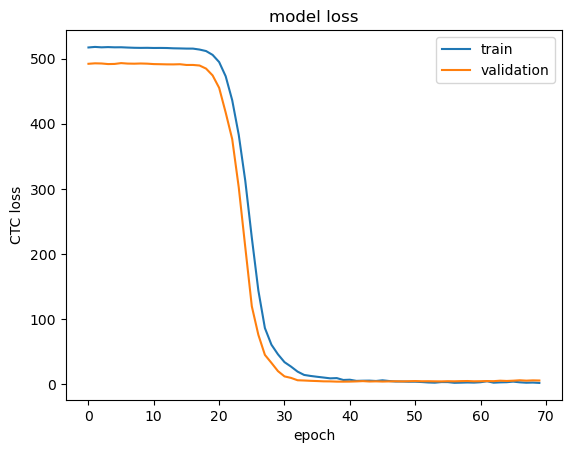

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('CTC loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Predictions

Now we have a trained model that performs well on both the training and validation sets from a CTC loss perspective. Let's shrink it to take only the layers that will be used to make predictions :

In [69]:
# Create the new prediction model
prediction_model = keras.models.Model(
    model.input[0], 
    model.get_layer(name="dense2").output
)

# Print the summary of the new model
prediction_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 20)              │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

Let's use this model to predict the labels for the 104 images of the validation set :

In [80]:
y_pred = prediction_model.predict(X_test) # y_pred shape = (104,50,20)
y_pred = keras.backend.ctc_decode(y_pred, input_length=np.ones(188)*50, greedy=True) # decoding -> y_pred[0].shape = (104,5)
#y_pred[0][0][X][0:5] corresponds to the prediction of one image (with X in [0,...,103])
#it is a tensor whose corresponding numpy array is for example [15,  7, 15, 12,  8]
y_pred = y_pred[0][0][0:188,0:5].numpy() # y_pred.shape=(104,5)
#array([[ 2,  2,  8,  0,  0],
#       [15,  7, 15, 12,  8],
#       ...
#       [13, 17, 13, 16,  2],
#       [10,  3, 14,  4,  4]])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Let's display 10 images and their predicted labels. This model is really making great:

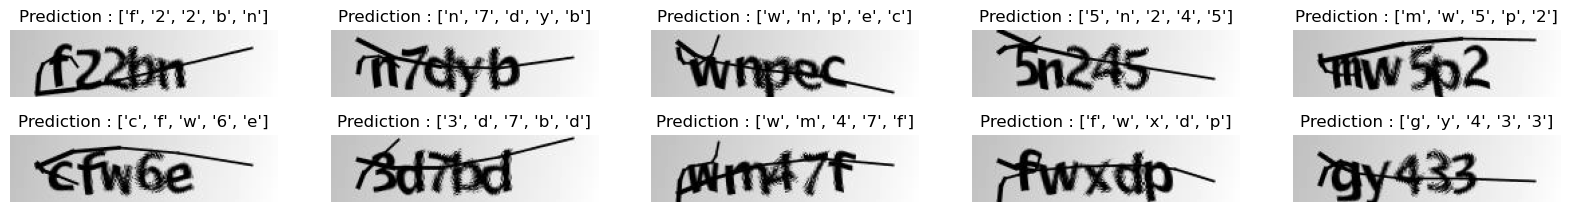

In [81]:
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_test[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()    


## Model performance

Let's use the function compute_perf_metric to calculate the performance metric of this model. Reminder : this metric corresponds to the percentage of characters that are correctly predicted (and this % is calculated using the 104 images hence 520 characters of the validation set).

In [82]:
compute_perf_metric(y_pred, y_test)

0.9968085106382979

In [83]:
compute_act_metric(y_pred, y_test)

0.9946808510638298

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

In [97]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super(CTCLayer, self).__init__(name=name)

    def call(self, y_true, y_pred):
        # Ensure shapes are as expected for CTC loss
        batch_size = tf.shape(y_true)[0]
        input_length = tf.shape(y_pred)[1]
        label_length = tf.shape(y_true)[1]

        # Compute CTC loss
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=tf.fill([batch_size], tf.shape(y_true)[1]), # Assuming labels have fixed length
            logit_length=tf.fill([batch_size], tf.shape(y_pred)[1]),
            logits_time_major=False,
            blank_index=-1
        )

        # Add loss to the layer
        self.add_loss(tf.reduce_mean(loss))
        return y_pred

def residual_block(x, filters, kernel_size=3, stride=1, downsample=False):
    """
    Define a residual block with optional downsampling.
    """
    shortcut = x
    
    if downsample:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the shortcut to the output
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def simple_resnet(input_shape, num_classes):
    """
    Define a simplified residual network with 5 convolutional layers.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolution
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Residual Blocks
    x = residual_block(x, 64)  # First block
    x = residual_block(x, 128, stride=2, downsample=True)  # second block
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

def build_model(num_classes=20):
    # Input layers
    input_img = layers.Input(shape=(200, 50, 1), name="image")  # Grayscale image input
    labels = layers.Input(name="label", shape=(None,), dtype="int32")

    # Convert grayscale to RGB by repeating channels
    x = layers.Conv2D(3, (1, 1), padding='same', use_bias=False)(input_img)
    
    # Load the simplified ResNet model
    base_model = simple_resnet(input_shape=(200, 50, 3), num_classes=num_classes)
    
    # Pass through ResNet
    x = base_model(x)

    # Reshape for RNN input
    x = layers.Reshape(target_shape=(1, num_classes))(x)

    # Simple RNN layer
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(num_classes, activation="softmax")(x)  # num_classes = number of characters + 1 (for blank)

    # CTC layer for loss computation
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = models.Model(inputs=[input_img, labels], outputs=output, name="ocr_resnet5_lstm_model")

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam())
    return model

# Create and summarize the model
model = build_model()
model.summary()


Model: "ocr_resnet5_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 200, 50, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_35 (Conv2D)            │ (None, 200, 50, 3)        │               3 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ functional_12 (Functional)    │ (None, 20)                │         317,972 │ conv2d_35[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_5 (Reshape)           │ (None, 1, 20)             │               0 │ functional_12[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_21              │ (None, 1, 256)            │         152,576 │ reshape_5[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 1, 20)             │           5,140 │ bidirectional_21[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_loss (CTCLayer)           │ (None, 1, 20)             │               0 │ label[0][0],               │
│                               │                           │                 │ dense_11[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 475,691 (1.81 MB)

 Trainable params: 474,539 (1.81 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [98]:
X_train, X_val, y_train, y_val,X_test,y_test = create_train_and_validation_datasets(crop=False)

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)

# Train the model
history = model.fit(
    x={'image': X_train, 'label': y_train}, 
    validation_data=({'image': X_val, 'label': y_val}),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - loss: 709.1938 - val_loss: 709.1875
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 709.1759 - val_loss: 709.1423
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 709.0964 - val_loss: 708.9005
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 708.8379 - val_loss: 708.6829
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 708.6968 - val_loss: 708.6634
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 708.6785 - val_loss: 708.6605
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 708.6698 - val_loss: 708.6595
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 708.6700 - val_loss: 708.6591
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 708.6657 - val_loss: 708.6589
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 708.6625 - val_loss: 708.6588
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 708.6620 - val_loss: 708.658

In [102]:
# Create the new prediction model
prediction_model = keras.models.Model(
    model.input[0], 
    model.get_layer(name="dense_11").output
)

# Print the summary of the new model
prediction_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 200, 50, 3)          │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_12 (Functional)           │ (None, 20)                  │         317,972 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 1, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 1, 256)              │         152,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1, 20)               │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,691 (1.81 MB)

 Trainable params: 474,539 (1.81 MB)

 Non-trainable params: 1,152 (4.50 KB)

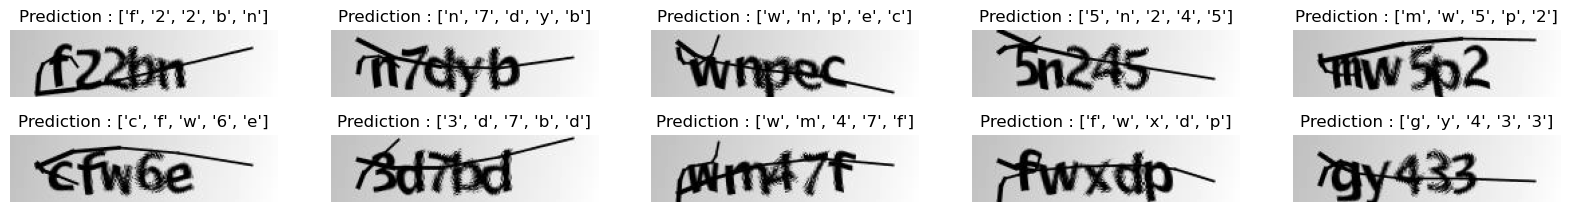

In [103]:
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_test[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()    


In [104]:
compute_perf_metric(y_pred, y_test)

0.9968085106382979

In [105]:
compute_act_metric(y_pred, y_test)

0.9946808510638298

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
IMAGE_WIDTH = 50
IMAGE_HEIGHT = 200
CHANNELS = 1  # Grayscale images

# Define the generator model
def build_generator():
    model = models.Sequential()
    
    # Starting with a Dense layer
    model.add(layers.Dense(12 * 50 * 128, activation='relu', input_dim=100))  # Adjust size for output shape
    model.add(layers.Reshape((50, 12, 128)))  # Adjust to match intermediate shape
    
    # First Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'))  # Output: 100x24x64
    
    # Second Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', activation='relu'))  # Output: 200x48x32
    
    # Third Conv2DTranspose layer to reach desired output shape
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid'))  # Output: 200x50x1
    model.add(layers.ZeroPadding2D(padding=(0, 1)))
    
    # Reorder dimensions to match the target shape (50, 200, 1)
    #model.add(layers.Permute((2, 1, 3)))  # Output: 50x200x1

    return model

# Define the discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Create and compile the models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Compile the discriminator and GAN
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Print model summaries
print("Generator Summary:")
generator.summary()

print("\nDiscriminator Summary:")
discriminator.summary()

print("\nGAN Summary:")
gan.summary()


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Generator Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 76800)               │       7,756,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 100, 24, 64)         │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 200, 48, 32)         │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 200, 48, 1)          │             801 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 200, 50, 1)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,013,697 (30.57 MB)

 Trainable params: 8,013,697 (30.57 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 25, 64)         │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 100, 25, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 25, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 13, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 50, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 83200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          83,201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 289,793 (1.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 289,793 (1.11 MB)


GAN Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 200, 50, 1)          │       8,013,697 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         289,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,303,490 (31.68 MB)

 Trainable params: 8,013,697 (30.57 MB)

 Non-trainable params: 289,793 (1.11 MB)

In [11]:
X_train, X_val, y_train, y_val,X_test,y_test = create_train_and_validation_datasets(crop=False)

In [ ]:
# Training the GAN
def train_gan(generator, discriminator, gan, X_train, epochs, batch_size=32):
    num_samples = X_train.shape[0]
    for epoch in range(epochs):
        # Select a random batch of real images
        idx = np.random.randint(0, num_samples, batch_size)
        real_images = X_train[idx]
        
        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)
        
        # Ensure generated images and real images have the same dimensions
        assert real_images.shape[1:] == generated_images.shape[1:], \
            f"Mismatch: real_images shape {real_images.shape[1:]} != generated_images shape {generated_images.shape[1:]}"
        
        # Combine real and fake images
        combined_images = np.concatenate([real_images, generated_images])
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        
        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, misleading_labels)
        
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

# Load and preprocess the X_train data
# Ensure X_train has shape (1040, 50, 200, 1)
# Example (you should replace this with your actual data loading code):
# X_train = load_your_captcha_images()
# X_train = preprocess_images(X_train)  # Normalize images to range [0, 1]

# Ensure X_train has the correct shape and values
X_train = (X_train - 0.5) / 0.5  # Normalize images to range [-1, 1]

# Train the GAN
train_gan(generator, discriminator, gan, X_train, epochs=1000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
0 [D loss: 2.108098268508911] [G loss: [array(2.1080983, dtype=float32), array(2.1080983, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


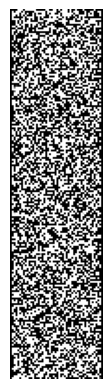

In [25]:
# Generate and display an example image
def generate_image(generator):
    noise = np.random.normal(0, 1, (1, 100))
    generated_image = generator.predict(noise)[0]
    plt.imshow(generated_image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    plt.axis('off')
    plt.show()

# Generate an image after training
generate_image(generator)